In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import random
import math
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit

from datetime import datetime, timedelta
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from sklearn.preprocessing import StandardScaler

from rpy2.robjects.packages import importr
from rpy2.robjects import robject

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import rpy2.ipython.html
# rpy2.ipython.html.init_printing()

rTE = importr('RTransferEntropy')
rTE.set_quiet(True)

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fd1d58b5380> [RTYPES.NILSXP]

In [2]:
from core.functions import *
from core.preprocess import *

# setup seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

SEED = 12345
seed_everything(SEED)

# Generate Data

In [3]:
# 1. Generate random data
x,y = generate_samples()

In [4]:
# 2. Load generated data
x = pd.read_csv('data/x.csv', header=None)
y = pd.read_csv('data/y.csv', header=None)
lag = 10 # true value

In [5]:
x = x.squeeze()
y = y.squeeze()

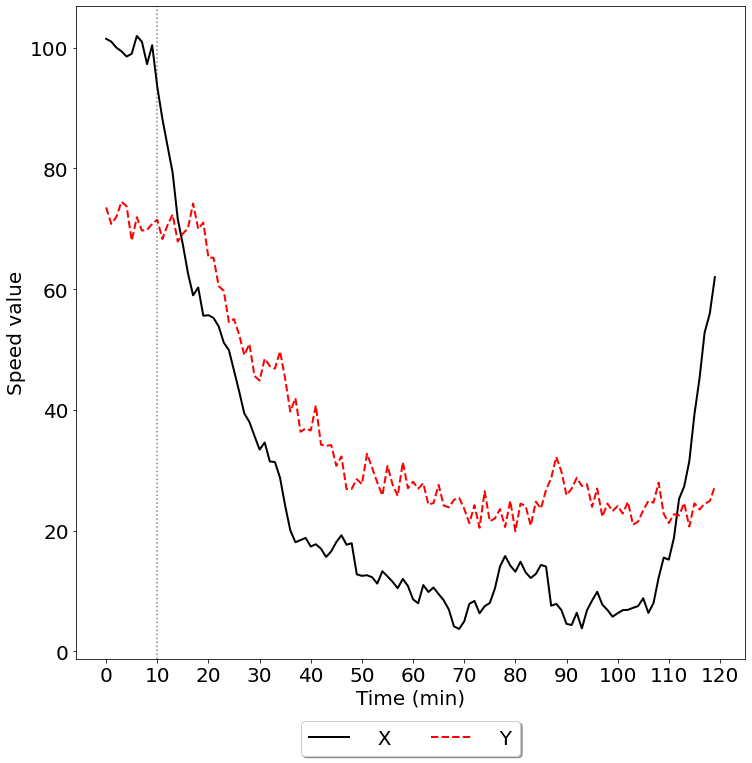

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.plot(x, color='k', lw=2)
ax.plot(y, color='r', ls='dashed', lw=2)

ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(['  X','  Y'], loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=2, fontsize=20)
plt.show()

In [7]:
# Directories for output
if not os.path.exists('out'):
    os.mkdir('out')
if not os.path.exists('out/img'):
    os.mkdir('out/img')

  0%|          | 0/100 [00:00<?, ?it/s]

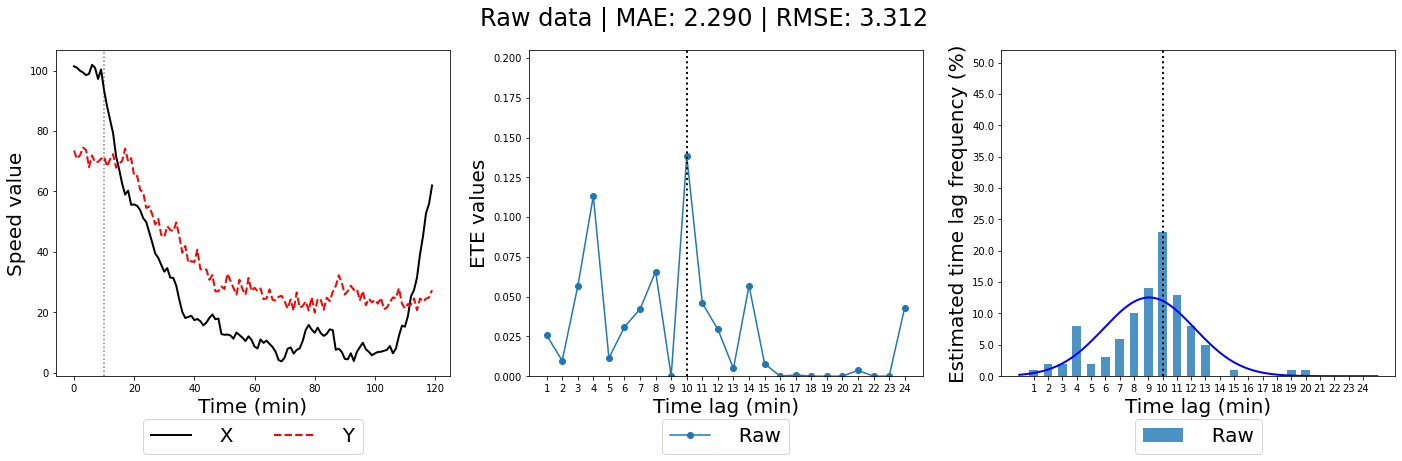

(9.07,
 2.29,
 3.312099032335839,
 (8.230898528883843, 9.909101471116157),
 (9.07, 3.1788519940380993))

In [8]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x, y, lag=lag, plot=True, title = 'Raw data', save='raw', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [9]:
raw = [ETE_value, TE_boot_count, curve]

# Normalization without sliding window

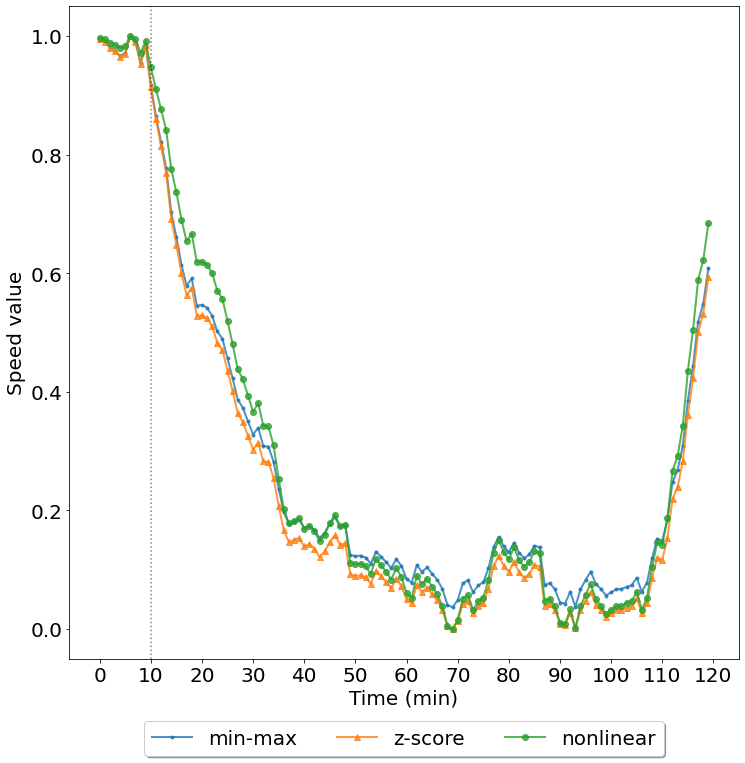

In [10]:
x_min_max = min_max(x)
x_z_score = z_score(x)
x_norm = nonlinear(x)
x_norm_scaled = nonlinear(x, scale=True)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_min_max, marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(x_z_score, marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(x_norm_scaled, marker='o', label='nonlinear', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('out/img/x.png', bbox_inches='tight')
plt.show()

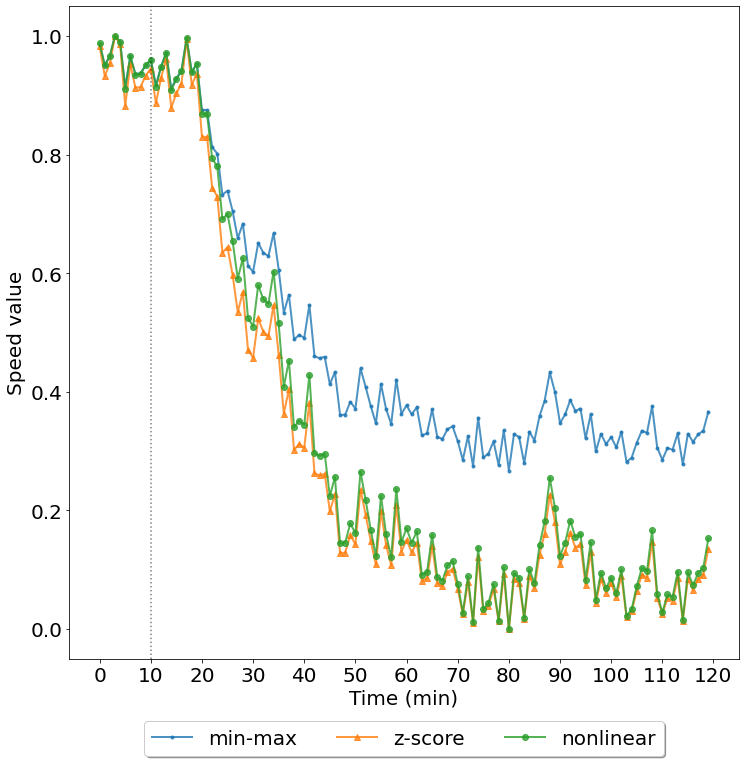

In [11]:
y_min_max = min_max(y)
y_z_score = z_score(y)
y_norm = nonlinear(y)
y_norm_scaled = nonlinear(y, scale=True)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_min_max, marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(y_z_score, marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(y_norm_scaled, marker='o', label='nonlinear', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('out/img/y.png', bbox_inches='tight')
plt.show()

# Compare results without slding winodow

  0%|          | 0/100 [00:00<?, ?it/s]

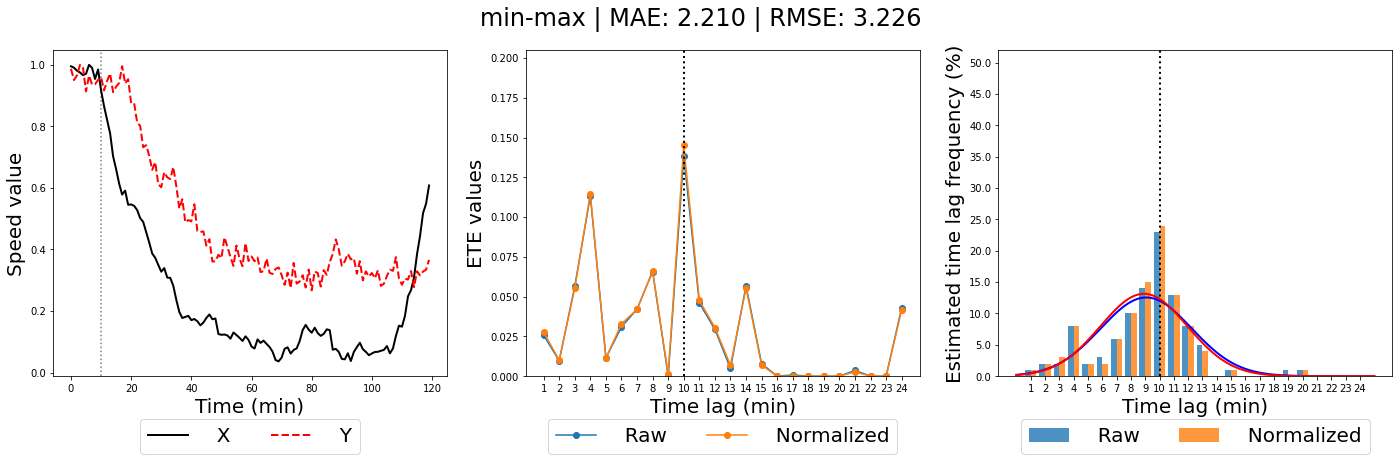

(8.91,
 2.21,
 3.2264531609803355,
 (8.108406145564912, 9.711593854435089),
 (8.91, 3.036758139859017))

In [12]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_min_max,y_min_max, lag=lag, plot=True, title = 'min-max', raw=raw, save='min_max', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

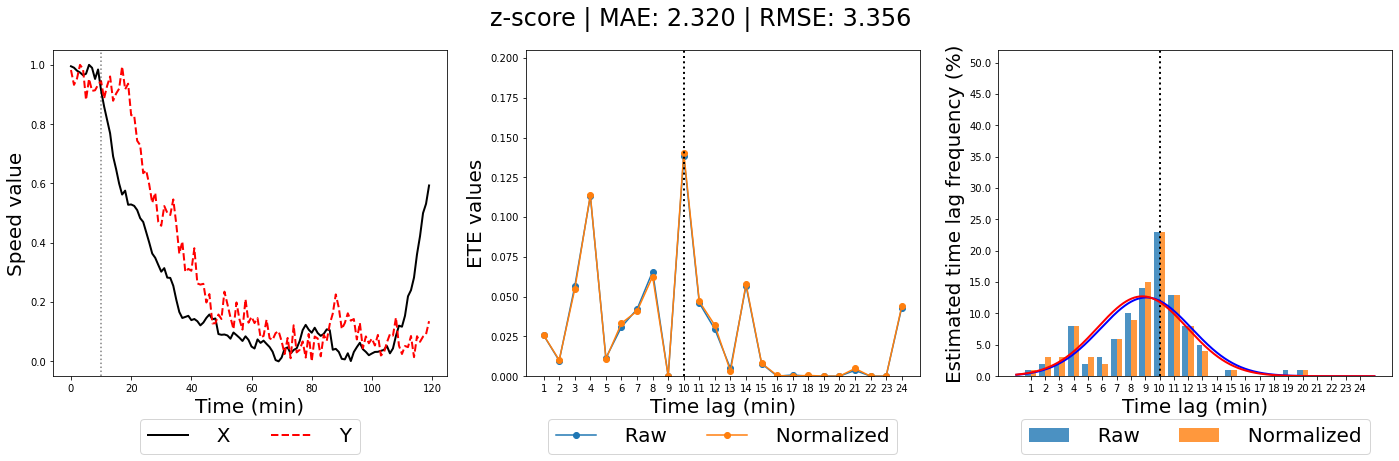

(8.8,
 2.32,
 3.3555923471125033,
 (7.972820203234898, 9.627179796765104),
 (8.8, 3.1336879231984796))

In [13]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_z_score,y_z_score, lag=lag, plot=True, title = 'z-score', raw=raw, save='z_score', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

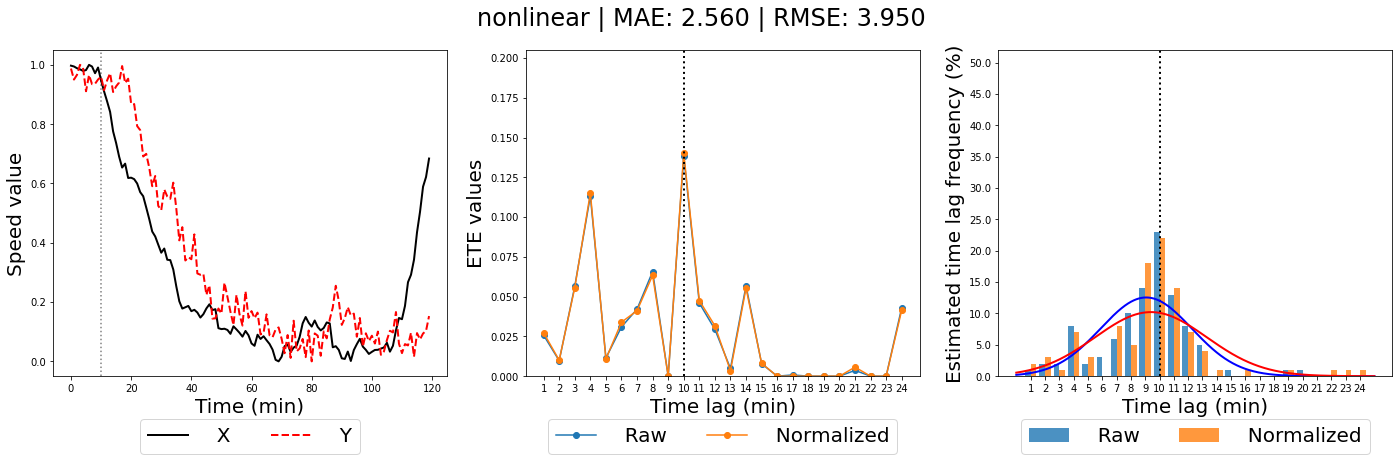

(9.4,
 2.56,
 3.9496835316262997,
 (8.369526902467584, 10.430473097532417),
 (9.4, 3.9038442591886273))

In [14]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                       title = 'nonlinear', raw=raw, save='nonlinear', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

# Consider free flow situation

In [15]:
period = 60

In [16]:
x_pre = [100] * period + np.random.normal(0, 1, period)*1
x = pd.Series(np.append(x_pre, x.to_numpy()))

In [17]:
y_pre = [70] * period + np.random.normal(0, 1, period)*1
y = pd.Series(np.append(y_pre, y.to_numpy()))

In [18]:
out = []
for lag_test in np.arange(1,25,1):
    x_copy = x.to_numpy().copy()
    y_copy = y.to_numpy().copy()

    ETE_value = rTE.calc_ete(x = x_copy[1:(len(x_copy)-lag_test)+1], y = y_copy[(lag_test):len(y_copy)],lx=1,ly=1)
    out.append([lag_test, np.asarray(ETE_value).item()])

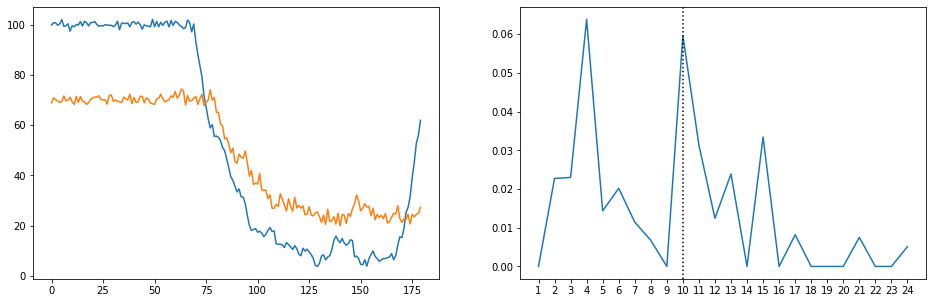

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(x)
ax[0].plot(y)

ax[1].plot(np.array(out)[:,0], np.array(out)[:,1])
ax[1].set_xticks(np.arange(1,25))
ax[1].axvline(lag, color='k', ls=':')

plt.show()

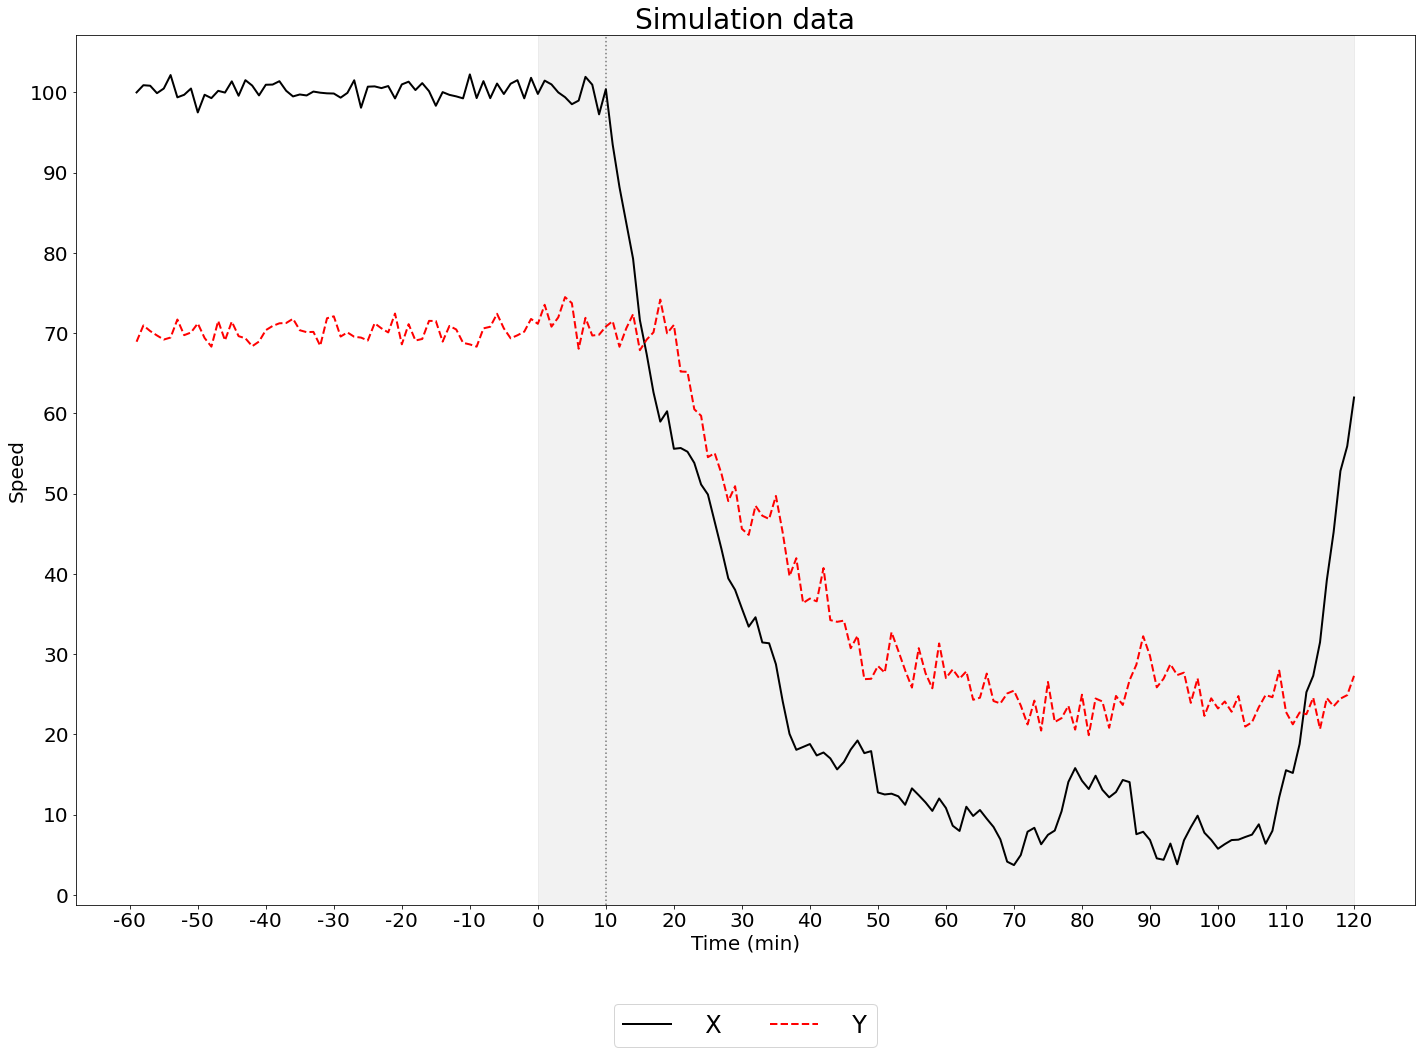

In [20]:
fig, ax = plt.subplots(1,1, figsize=(24,16)) 
ax.plot(x, color='k', lw=2)
ax.plot(y, color='r', ls='dashed', lw=2)

# ax.axvline(60-1, color='b', ls = ':', alpha=0.5)
# ax.axvline(180-1, color='b', ls = ':', alpha=0.5)
ax.axvspan(60-1, 180-1, alpha=0.1, color='gray')
ax.axvline(70-1, color='k', ls = ':', alpha=0.5)
plt.legend(['  X','  Y'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=24)

plt.title('Simulation data', fontsize=28)

ax.set_xticks(np.arange(-1, 180, 10))
ax.set_xticklabels(list(np.arange(-60,121, 10)), fontsize=20)
ax.set_yticks(np.arange(0, 110, 10))
ax.set_yticklabels(np.arange(0, 110, 10), fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed', fontsize=20)

plt.savefig('out/img/fig.png', bbox_inches='tight')
plt.show()

# Normalization with sliding window

In [21]:
period=20

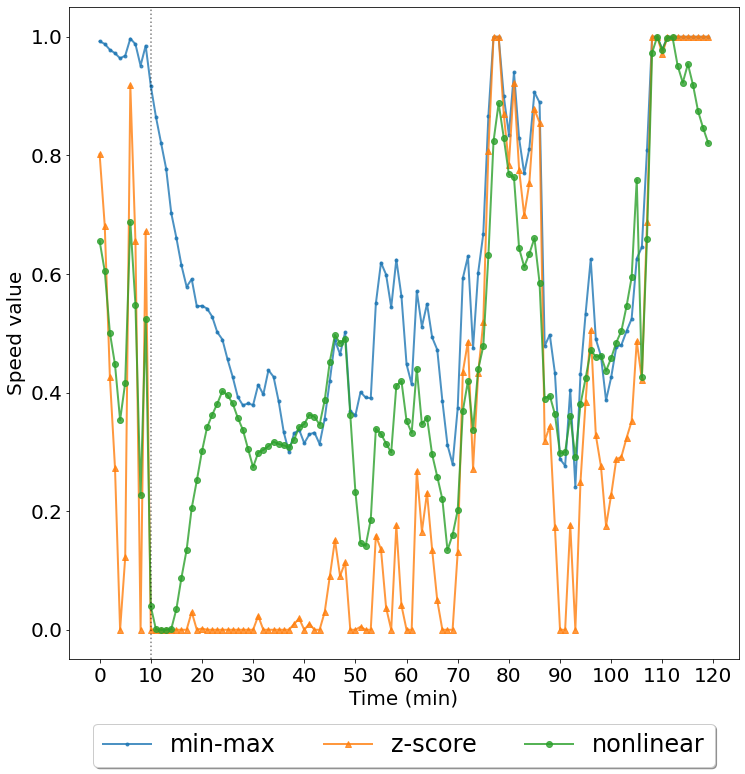

In [22]:
x_min_max = min_max(x, period=period)[-120:]
x_z_score = z_score(x, period=period)[-120:]
x_norm = nonlinear(x, period=period)[-120:]
x_norm_scaled = nonlinear(x, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_min_max.reset_index(drop=True), marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(x_z_score.reset_index(drop=True), marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(x_norm_scaled.reset_index(drop=True), marker='o', label='nonlinear', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=24)
plt.savefig('out/img/x_p.png', bbox_inches='tight')
plt.show()

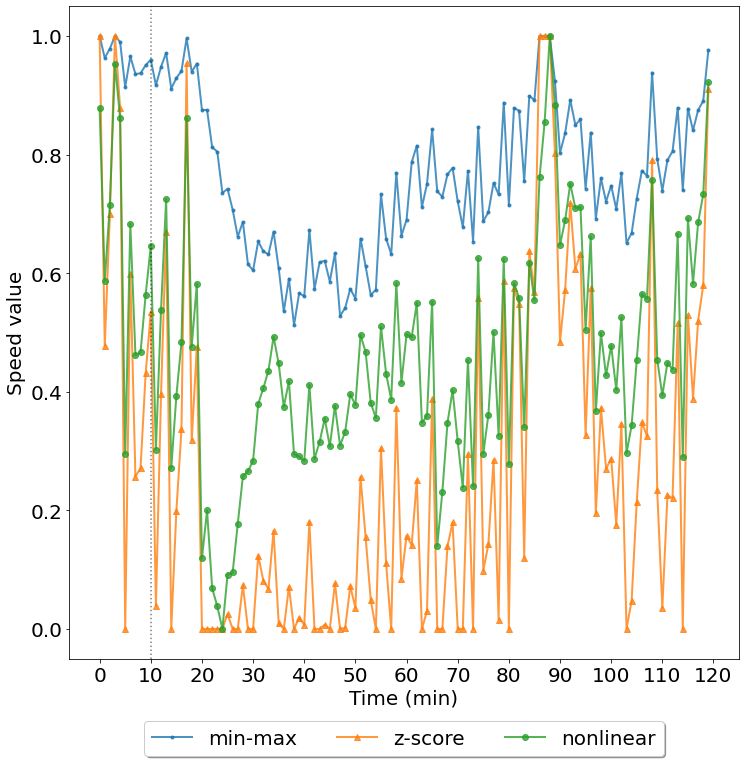

In [23]:
y_min_max = min_max(y, period=period)[-120:]
y_z_score = z_score(y, period=period)[-120:]
y_norm = nonlinear(y, period=period)[-120:]
y_norm_scaled = nonlinear(y, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_min_max.reset_index(drop=True), marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(y_z_score.reset_index(drop=True), marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(y_norm_scaled.reset_index(drop=True), marker='o', label='nonlinear', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('out/img/y_p.png', bbox_inches='tight')
plt.show()

# Compare results with slding winodow

  0%|          | 0/100 [00:00<?, ?it/s]

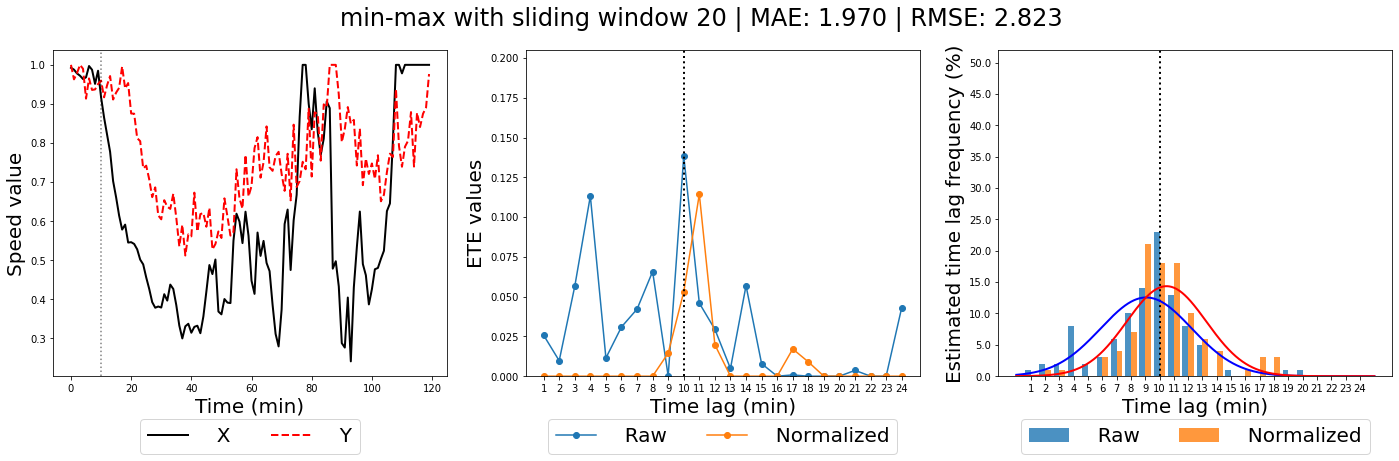

(10.49,
 1.97,
 2.8231188426986207,
 (9.756109759312098, 11.223890240687902),
 (10.49, 2.780269771083375))

In [24]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_min_max,y_min_max, lag=lag, plot=True, 
                                                                               title = 'min-max with sliding window {}'.format(period), raw=raw, save='min-max_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

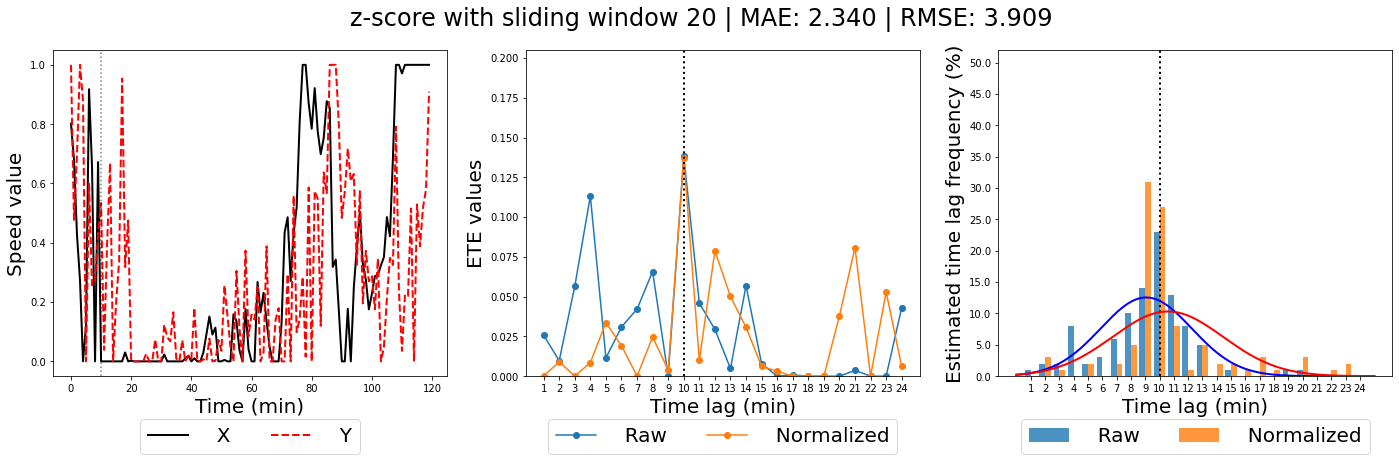

(10.58,
 2.34,
 3.9089640571384128,
 (9.559596847334968, 11.600403152665033),
 (10.58, 3.865695280282708))

In [25]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_z_score,y_z_score, lag=lag, plot=True, 
                                                                               title = 'z-score with sliding window {}'.format(period), raw=raw, save='z-score_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

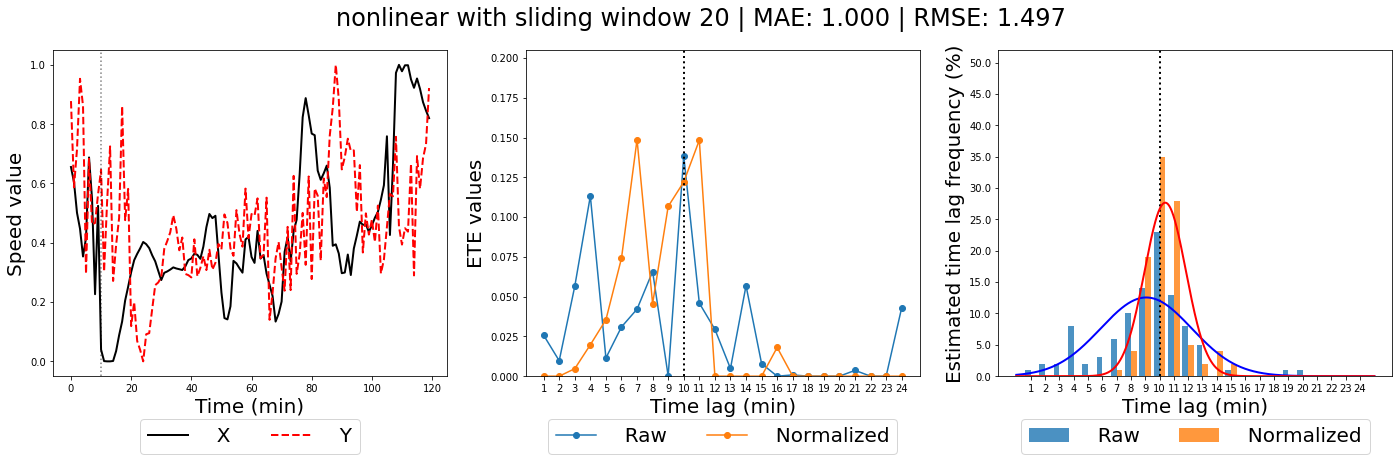

(10.4,
 1.0,
 1.4966629547095767,
 (10.019306166490203, 10.780693833509797),
 (10.4, 1.4422205101855956))

In [26]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                               title = 'nonlinear with sliding window {}'.format(period), raw=raw, save='nonlinear_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]